In [ ]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# data_gen = ImageDataGenerator(rescale=1/255, validation_split=0.2)

# train_data = data_gen.flow_from_directory(
#     "./dataset_final",
#     target_size=(128, 128),
#     batch_size=32,
#     class_mode="categorical",
#     subset="training"
# )

# val_data = data_gen.flow_from_directory(
#     "./dataset_final",
#     target_size=(128, 128),
#     batch_size=32,
#     class_mode="categorical",
#     subset="validation"
# )

# print("Total de imágenes de entrenamiento:", train_data.samples)
# print("Total de imágenes de validación:", val_data.samples)




In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Ruta al dataset
data_dir = "./dataset_final"

# Parámetros
img_height, img_width = 64, 64  # puedes ajustar según tus imágenes
batch_size = 32

# Cargar dataset dividido en entrenamiento y validación
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Guardar las clases
class_names = train_ds.class_names
num_classes = len(class_names)
print("Clases:", class_names)

# Normalizar después
train_ds = train_ds.map(lambda x, y: (x / 255.0, y))
val_ds = val_ds.map(lambda x, y: (x / 255.0, y))

Found 6754 files belonging to 7 classes.
Using 5404 files for training.
Found 6754 files belonging to 7 classes.
Using 1350 files for validation.
Clases: ['enojado', 'feliz', 'muerto', 'nervioso', 'neutral', 'sorprendida', 'triste']


In [ ]:
num_classes = len(class_names)

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D(2,2),
    
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


c:\Users\angel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
epochs = 15

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)


Epoch 1/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.5263 - loss: 1.2595 - val_accuracy: 0.8022 - val_loss: 0.5989
Epoch 2/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8581 - loss: 0.4060 - val_accuracy: 0.9326 - val_loss: 0.2140
Epoch 3/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9473 - loss: 0.1587 - val_accuracy: 0.9652 - val_loss: 0.1083
Epoch 4/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9685 - loss: 0.0917 - val_accuracy: 0.9637 - val_loss: 0.1052
Epoch 5/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9796 - loss: 0.0604 - val_accuracy: 0.9785 - val_loss: 0.0792
Epoch 6/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9848 - loss: 0.0522 - val_accuracy: 0.9556 - val_loss: 0.1646
Epoch 7/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9848 - loss: 0.0470 - val_accuracy: 0.9837 - val_loss: 0.0630
Epoch 8/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9948 - loss: 0.0200 - val_accu

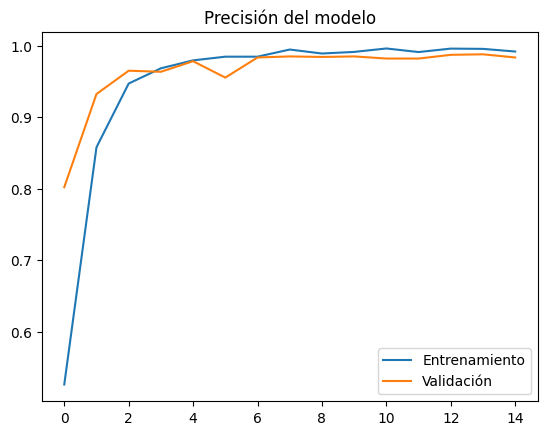

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

import matplotlib.pyplot as plt
plt.plot(acc, label='Entrenamiento')
plt.plot(val_acc, label='Validación')
plt.legend()
plt.title('Precisión del modelo')
plt.show()


In [17]:
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array

img_path = "./prueba.png"

img = load_img(img_path, target_size=(img_height, img_width))
img_array = img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

predictions = model.predict(img_array)
pred_class = class_names[np.argmax(predictions)]

print(f"Predicción: {pred_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicción: feliz
Predicción: feliz


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

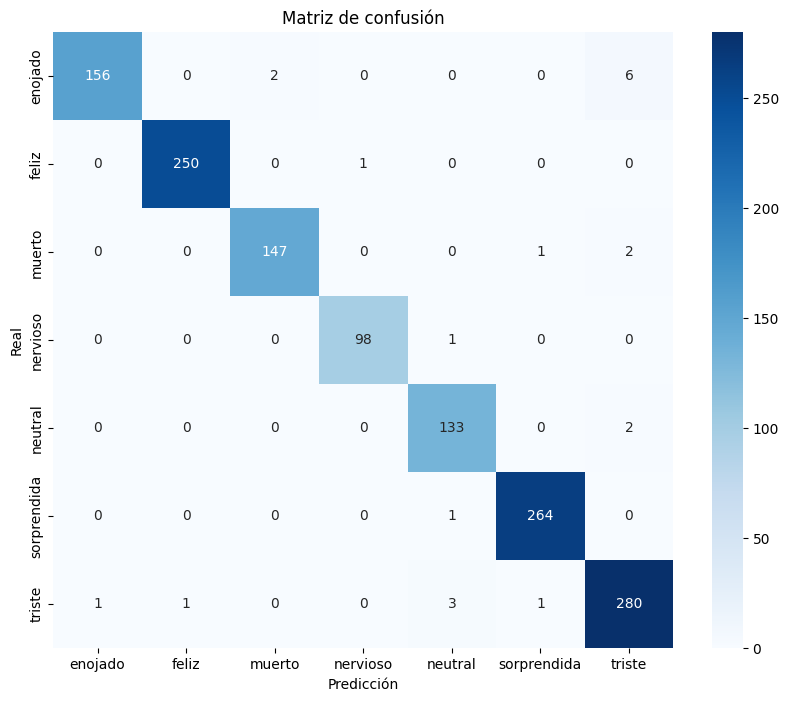

Reporte de clasificación:
              precision    recall  f1-score   support

     enojado       0.99      0.95      0.97       164
       feliz       1.00      1.00      1.00       251
      muerto       0.99      0.98      0.98       150
    nervioso       0.99      0.99      0.99        99
     neutral       0.96      0.99      0.97       135
 sorprendida       0.99      1.00      0.99       265
      triste       0.97      0.98      0.97       286

    accuracy                           0.98      1350
   macro avg       0.98      0.98      0.98      1350
weighted avg       0.98      0.98      0.98      1350



In [18]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Obtener predicciones sobre el set de validación
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Convertir a arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_names,
            yticklabels=class_names,
            cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de confusión')
plt.show()

# Reporte de métricas
print("Reporte de clasificación:")
print(classification_report(y_true, y_pred, target_names=class_names))
